
Top Customers Monthly Trends Test (Profit)
H₀: Profit distributions for top customers are equal across all months.
H₁: Profit distributions for top customers differ across months.
Normality (D'Agostino K², Month Jan, n=56): Failed (p=0.0000)
Normality (Shapiro-Wilk, Month Feb, n=32): Failed (p=0.0000)
Normality (D'Agostino K², Month Mar, n=92): Failed (p=0.0000)
Normality (D'Agostino K², Month Apr, n=73): Failed (p=0.0000)
Normality (D'Agostino K², Month May, n=109): Failed (p=0.0000)
Normality (D'Agostino K², Month Jun, n=97): Failed (p=0.0000)
Normality (D'Agostino K², Month Jul, n=89): Failed (p=0.0000)
Normality (D'Agostino K², Month Aug, n=107): Failed (p=0.0000)
Normality (D'Agostino K², Month Sep, n=208): Failed (p=0.0000)
Normality (D'Agostino K², Month Oct, n=102): Failed (p=0.0000)
Normality (D'Agostino K², Month Nov, n=217): Failed (p=0.0000)
Normality (D'Agostino K², Month Dec, n=165): Failed (p=0.0000)
Normality test failed for at least one month.
Homogeneity of Variances

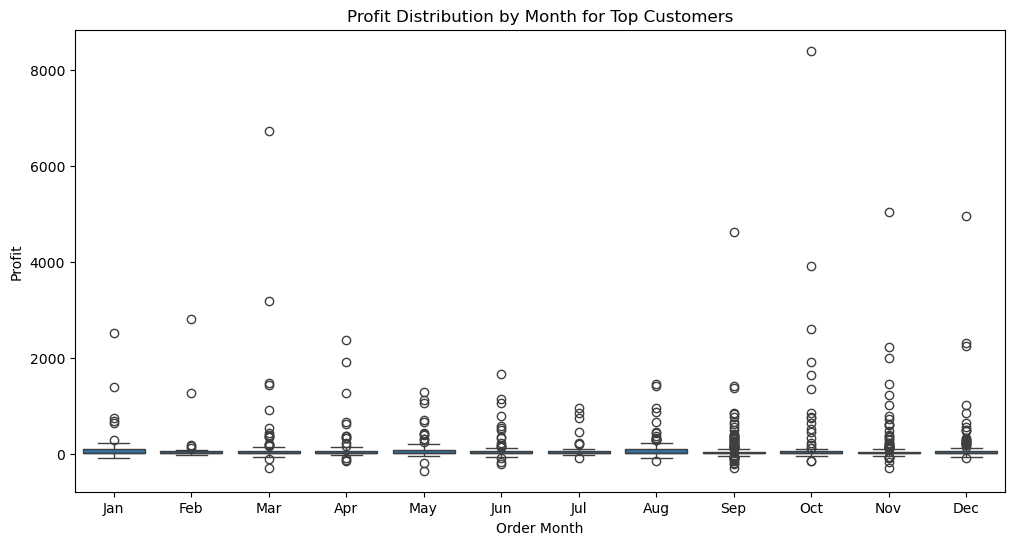

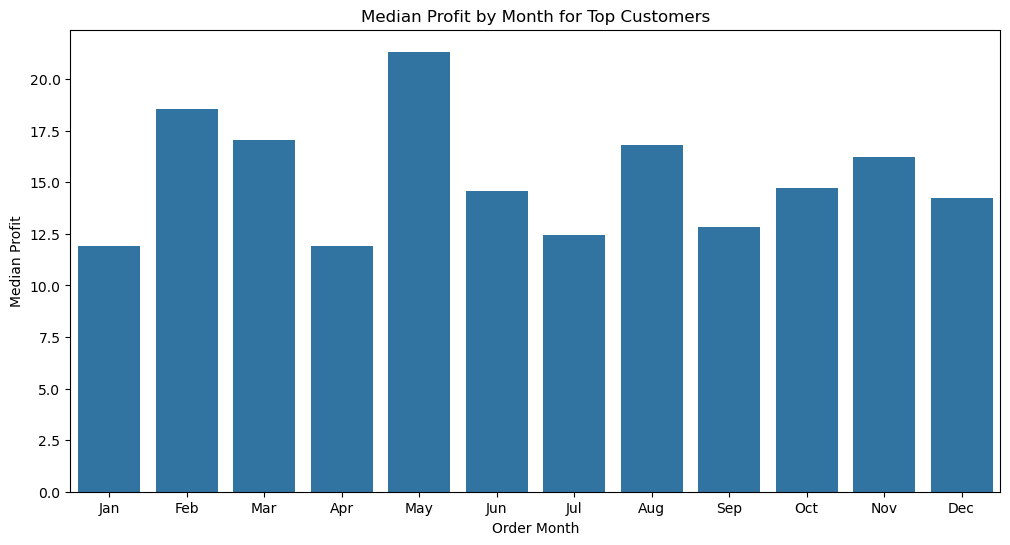

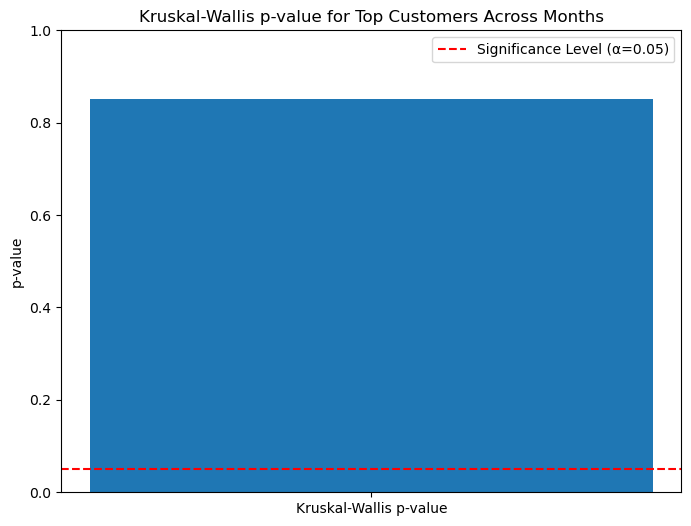

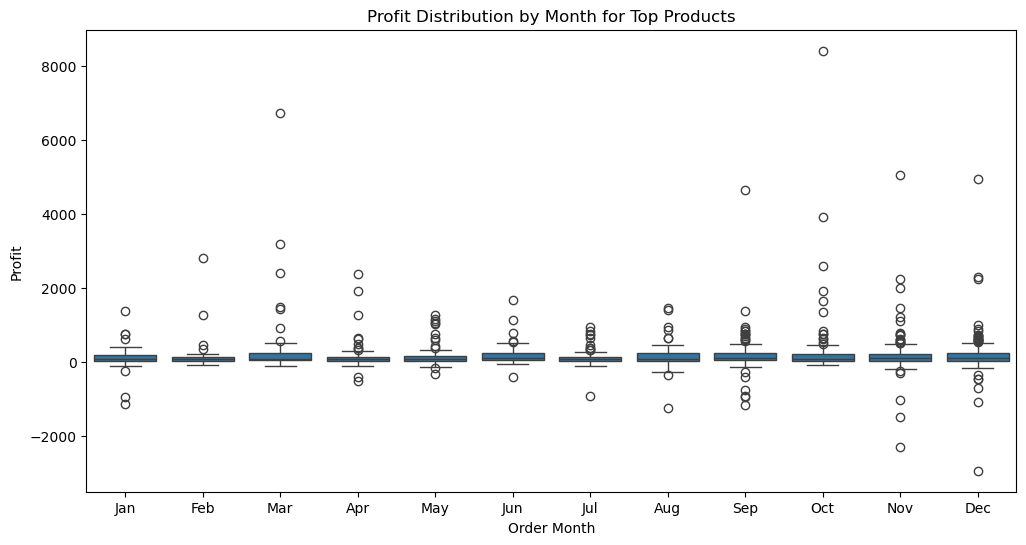

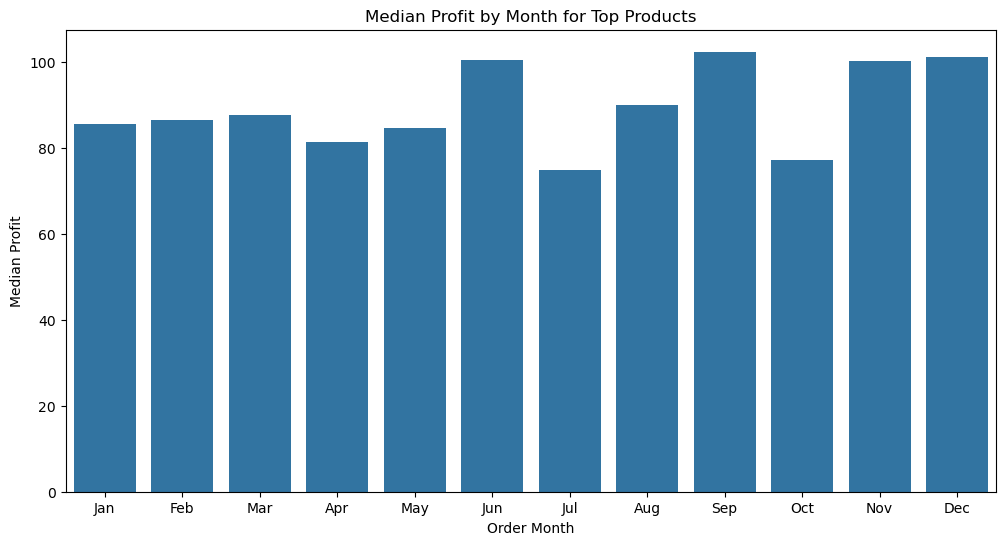

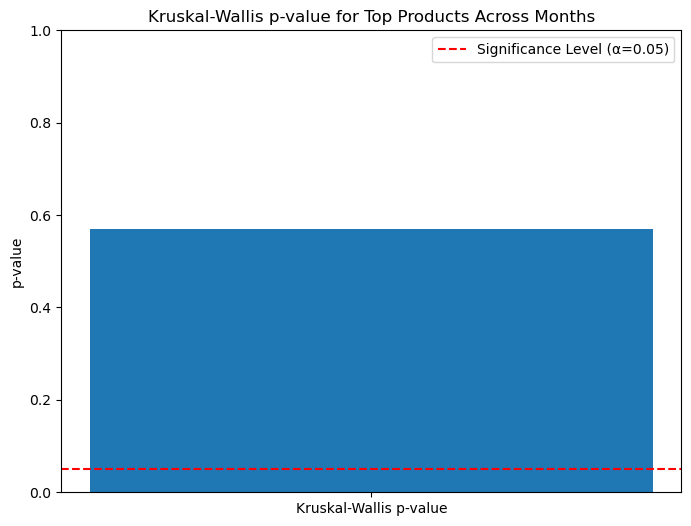

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed
np.random.seed(42)

# Load dataset
try:
    df = pd.read_csv('SampleSuperstoreClean.csv')
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Order Month'] = df['Order Date'].dt.strftime('%b')  # Use month names (Jan, Feb, etc.)
    alpha = 0.05
except FileNotFoundError:
    print("Error: 'SampleSuperstoreClean.csv' not found. Please ensure the file is in the correct directory.")
    raise
except KeyError as e:
    print(f"Error: Missing column {e}. Ensure 'Customer ID', 'Product ID', 'Sales', 'Profit', 'Order Date' exist.")
    raise

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality (Month {name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, Month {name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one month.")
    
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    if any(len(group) < 3 for group in data_groups):
        print("At least one month has insufficient data (<3); defaulting to Kruskal-Wallis.")
        return False
    
    return normality and homogeneity

def summarize_post_hoc(post_hoc, group_names):
    if isinstance(post_hoc, pd.DataFrame):
        significant_pairs = post_hoc[post_hoc < alpha].stack()
        if not significant_pairs.empty:
            print("\nSignificant Month Pairs (Dunn's Test):")
            for (m1, m2), p in significant_pairs.items():
                print(f"Month {m1} vs Month {m2}: p={p:.4f}")
        else:
            print("\nNo significant month pairs (Dunn's Test).")
        return post_hoc
    else:
        df_post_hoc = post_hoc.summary()
        significant_pairs = [(row[1], row[2], row[6]) for row in df_post_hoc.data if row[6] < alpha]
        if significant_pairs:
            print("\nSignificant Month Pairs (Tukey HSD):")
            for m1, m2, p in significant_pairs:
                print(f"Month {m1} vs Month {m2}: p={p:.4f}")
        else:
            print("\nNo significant month pairs (Tukey HSD).")
        return None

def rank_months(df, metric, group_col='Order Month'):
    medians = df.groupby(group_col)[metric].median().reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']).dropna()
    print(f"\nRanking of Months by Median {metric}:")
    for month, median in medians.items():
        print(f"Month {month}: {median:.2f}")
    return medians

def plot_median_bar(medians, metric, title, filename, group_col='Order Month'):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=medians.index, y=medians.values)
    plt.title(title)
    plt.xlabel(group_col)
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()

def plot_kruskal_pvalue_bar(p_value, title, filename):
    plt.figure(figsize=(8, 6))
    plt.bar(['Kruskal-Wallis p-value'], [p_value])
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (α=0.05)')
    plt.title(title)
    plt.ylabel('p-value')
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig(filename)
    plt.show()

def plot_post_hoc_heatmap(post_hoc, metric, filename):
    if post_hoc is not None:
        if not isinstance(post_hoc, pd.DataFrame):
            print(f"Error: post_hoc is not a DataFrame, got {type(post_hoc)}")
            return
        
        group_names = post_hoc.index.tolist()
        if post_hoc.shape[0] != post_hoc.shape[1] or post_hoc.shape[0] != len(group_names):
            print(f"Error: post_hoc shape {post_hoc.shape} is not square or does not match index length")
            return
        
        if not np.all(post_hoc.apply(pd.to_numeric, errors='coerce').notnull()):
            print("Error: post_hoc contains non-numeric values")
            return
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            post_hoc,
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'p-value'},
            square=True,
            annot_kws={'size': 10},
        )
        plt.title(f"Post-hoc Dunn's Test p-values for {metric}", pad=20)
        plt.xticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=0)
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        print("No post-hoc results to plot.")

# Identify top performers
customer_profit = df.groupby('Customer ID')['Profit'].sum().sort_values(ascending=False)
if customer_profit.empty:
    print("Error: No customer profit data available.")
    raise ValueError("Customer profit data is missing.")
top_customer_ids = customer_profit.head(int(len(customer_profit) * 0.1)).index
top_customers_df = df[df['Customer ID'].isin(top_customer_ids)]
if top_customers_df.empty:
    print("Error: No data for top customers.")
    raise ValueError("Top customers dataframe is empty.")

product_profit = df.groupby('Product ID')['Profit'].sum().sort_values(ascending=False)
if product_profit.empty:
    print("Error: No product profit data available.")
    raise ValueError("Product profit data is missing.")
top_product_ids = product_profit.head(int(len(product_profit) * 0.1)).index
top_products_df = df[df['Product ID'].isin(top_product_ids)]
if top_products_df.empty:
    print("Error: No data for top products.")
    raise ValueError("Top products dataframe is empty.")

# Monthly Trends Analysis for Top Customers (Profit)
print("\nTop Customers Monthly Trends Test (Profit)")
print("H₀: Profit distributions for top customers are equal across all months.")
print("H₁: Profit distributions for top customers differ across months.")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_profits_customers = [top_customers_df[top_customers_df['Order Month'] == m]['Profit'].dropna() for m in month_names]
if not any(len(series) > 0 for series in month_profits_customers):
    print("Error: No valid profit data for top customers in any month.")
    raise ValueError("Profit data for top customers is missing for all months.")

if check_assumptions(month_profits_customers, month_names):
    month_test_customers = stats.f_oneway(*month_profits_customers)
    test_name_customers = "ANOVA"
    post_hoc = pairwise_tukeyhsd(top_customers_df['Profit'].dropna(), top_customers_df['Order Month'].dropna()) if month_test_customers.pvalue < alpha else None
else:
    month_test_customers = stats.kruskal(*month_profits_customers)
    test_name_customers = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(top_customers_df.dropna(subset=['Profit', 'Order Month']), val_col='Profit', group_col='Order Month', p_adjust='bonferroni') if month_test_customers.pvalue < alpha else None
print(f"{test_name_customers}: Statistic={month_test_customers.statistic:.2f}, p={month_test_customers.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profits differ significantly, supporting monthly tracking of top customers." if month_test_customers.pvalue < alpha else "Fail to reject H₀; insufficient evidence for monthly tracking.")

post_hoc_result_customers = None
if post_hoc is not None:
    post_hoc_result_customers = summarize_post_hoc(post_hoc, month_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate shifts in customer performance, justifying monthly tracking.")

# Descriptive Statistics for Top Customers
customer_month_medians = rank_months(top_customers_df, 'Profit')

# Monthly Trends Analysis for Top Products (Profit)
print("\nTop Products Monthly Trends Test (Profit)")
print("H₀: Profit distributions for top products are equal across all months.")
print("H₁: Profit distributions for top products differ across months.")
month_profits_products = [top_products_df[top_products_df['Order Month'] == m]['Profit'].dropna() for m in month_names]
if not any(len(series) > 0 for series in month_profits_products):
    print("Error: No valid profit data for top products in any month.")
    raise ValueError("Profit data for top products is missing for all months.")

if check_assumptions(month_profits_products, month_names):
    month_test_products = stats.f_oneway(*month_profits_products)
    test_name_products = "ANOVA"
    post_hoc = pairwise_tukeyhsd(top_products_df['Profit'].dropna(), top_products_df['Order Month'].dropna()) if month_test_products.pvalue < alpha else None
else:
    month_test_products = stats.kruskal(*month_profits_products)
    test_name_products = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(top_products_df.dropna(subset=['Profit', 'Order Month']), val_col='Profit', group_col='Order Month', p_adjust='bonferroni') if month_test_products.pvalue < alpha else None
print(f"{test_name_products}: Statistic={month_test_products.statistic:.2f}, p={month_test_products.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profits differ significantly, supporting monthly tracking of top products." if month_test_products.pvalue < alpha else "Fail to reject H₀; insufficient evidence for monthly tracking.")

post_hoc_result_products = None
if post_hoc is not None:
    post_hoc_result_products = summarize_post_hoc(post_hoc, month_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate shifts in product performance, justifying monthly tracking.")

# Descriptive Statistics for Top Products
product_month_medians = rank_months(top_products_df, 'Profit')

# Visualizations
# Top Customers
plt.figure(figsize=(12, 6))
sns.boxplot(x='Order Month', y='Profit', data=top_customers_df, order=month_names)
plt.title('Profit Distribution by Month for Top Customers')
plt.xlabel('Order Month')
plt.ylabel('Profit')
plt.savefig('month_profit_customers_boxplot.png')
plt.show()

plot_median_bar(customer_month_medians, 'Profit', 'Median Profit by Month for Top Customers', 'month_profit_customers_median_bar.png')

if post_hoc_result_customers is not None:
    plot_post_hoc_heatmap(post_hoc_result_customers, 'Profit (Customers)', 'month_profit_customers_posthoc_heatmap.png')

# Plot Kruskal-Wallis p-value for Top Customers if applicable
if test_name_customers == "Kruskal-Wallis":
    plot_kruskal_pvalue_bar(month_test_customers.pvalue, 'Kruskal-Wallis p-value for Top Customers Across Months', 'kruskal_wallis_pvalue_customers_bar.png')

# Top Products
plt.figure(figsize=(12, 6))
sns.boxplot(x='Order Month', y='Profit', data=top_products_df, order=month_names)
plt.title('Profit Distribution by Month for Top Products')
plt.xlabel('Order Month')
plt.ylabel('Profit')
plt.savefig('month_profit_products_boxplot.png')
plt.show()

plot_median_bar(product_month_medians, 'Profit', 'Median Profit by Month for Top Products', 'month_profit_products_median_bar.png')

if post_hoc_result_products is not None:
    plot_post_hoc_heatmap(post_hoc_result_products, 'Profit (Products)', 'month_profit_products_posthoc_heatmap.png')

# Plot Kruskal-Wallis p-value for Top Products if applicable
if test_name_products == "Kruskal-Wallis":
    plot_kruskal_pvalue_bar(month_test_products.pvalue, 'Kruskal-Wallis p-value for Top Products Across Months', 'kruskal_wallis_pvalue_products_bar.png')

In [14]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)

# Load dataset
try:
    df = pd.read_csv('SampleSuperstoreClean.csv')
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Order Month'] = df['Order Date'].dt.strftime('%b')  # Use month names (Jan, Feb, etc.)
except FileNotFoundError:
    print("Error: 'SampleSuperstoreClean.csv' not found. Please ensure the file is in the correct directory.")
    raise
except KeyError as e:
    print(f"Error: Missing column {e}. Ensure 'Customer ID', 'Product ID', 'Sales', 'Profit', 'Order Date' exist.")
    raise

# Identify top performers
# Top 10% customers by total profit
customer_profit = df.groupby('Customer ID')['Profit'].sum().sort_values(ascending=False)
if customer_profit.empty:
    raise ValueError("Customer profit data is missing.")
top_customer_ids = customer_profit.head(int(len(customer_profit) * 0.1)).index
top_customers_df = df[df['Customer ID'].isin(top_customer_ids)].copy()  # Create explicit copy
if top_customers_df.empty:
    raise ValueError("Top customers dataframe is empty.")

# Top 10% products by total profit
product_profit = df.groupby('Product ID')['Profit'].sum().sort_values(ascending=False)
if product_profit.empty:
    raise ValueError("Product profit data is missing.")
top_product_ids = product_profit.head(int(len(product_profit) * 0.1)).index
top_products_df = df[df['Product ID'].isin(top_product_ids)].copy()  # Create explicit copy
if top_products_df.empty:
    raise ValueError("Top products dataframe is empty.")

# Filter out months with insufficient data (<5 observations)
min_obs = 5
valid_months_customers = top_customers_df['Order Month'].value_counts()[top_customers_df['Order Month'].value_counts() >= min_obs].index
valid_months_products = top_products_df['Order Month'].value_counts()[top_products_df['Order Month'].value_counts() >= min_obs].index
top_customers_df = top_customers_df[top_customers_df['Order Month'].isin(valid_months_customers)]
top_products_df = top_products_df[top_products_df['Order Month'].isin(valid_months_products)]

# Ensure at least two valid months
if top_customers_df['Order Month'].nunique() < 2 or top_products_df['Order Month'].nunique() < 2:
    raise ValueError("Insufficient valid months with enough observations (>=5) for customers or products.")

# Convert Order Month to categorical
top_customers_df.loc[:, 'Order Month'] = top_customers_df['Order Month'].astype('category')
top_products_df.loc[:, 'Order Month'] = top_products_df['Order Month'].astype('category')

# Encode Order Month as dummy variables (Jan as baseline)
top_customers_encoded = pd.get_dummies(top_customers_df, columns=['Order Month'], prefix='', prefix_sep='')  # Drops Jan
top_products_encoded = pd.get_dummies(top_products_df, columns=['Order Month'], prefix='', prefix_sep='')  # Drops Jan

# Prepare formula based on available dummy variables
month_names = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  # Ordered months after Jan
month_cols = [month for month in month_names if month in top_customers_encoded.columns]
if not month_cols:
    raise ValueError("No valid month dummy variables found for customers.")
formula_profit_customers = 'Profit ~ ' + ' + '.join(month_cols)

month_cols_products = [month for month in month_names if month in top_products_encoded.columns]
if not month_cols_products:
    raise ValueError("No valid month dummy variables found for products.")
formula_profit_products = 'Profit ~ ' + ' + '.join(month_cols_products)

# Quantile Regression for Top Customers (Profit, median, q=0.5)
quantile_model_customers = smf.quantreg(formula_profit_customers, top_customers_encoded.dropna(subset=['Profit'] + month_cols)).fit(q=0.5)
print("=== Quantile Regression for Top Customers Profit ===")
print(quantile_model_customers.summary())

# Business-Friendly Interpretations for Top Customers
print("\n=== Business-Friendly Interpretations (Top Customers) ===")
print(f"Profit Model (y = b0 + {' + '.join([f'b{i}*{month_cols[i]}' for i in range(len(month_cols))])}):")
for param, value in quantile_model_customers.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit (Jan): {value:.2f}")
    else:
        month = param.replace('[T.True]', '')
        print(f"Switching to Month {month} changes median Profit by {value:.2f} compared to Jan.")

# Quantile Regression for Top Products (Profit, median, q=0.5)
quantile_model_products = smf.quantreg(formula_profit_products, top_products_encoded.dropna(subset=['Profit'] + month_cols_products)).fit(q=0.5)
print("\n=== Quantile Regression for Top Products Profit ===")
print(quantile_model_products.summary())

# Business-Friendly Interpretations for Top Products
print("\n=== Business-Friendly Interpretations (Top Products) ===")
print(f"Profit Model (y = b0 + {' + '.join([f'b{i}*{month_cols_products[i]}' for i in range(len(month_cols_products))])}):")
for param, value in quantile_model_products.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit (Jan): {value:.2f}")
    else:
        month = param.replace('[T.True]', '')
        print(f"Switching to Month {month} changes median Profit by {value:.2f} compared to Jan.")

=== Quantile Regression for Top Customers Profit ===
                         QuantReg Regression Results                          
Dep. Variable:                 Profit   Pseudo R-squared:            0.0007386
Model:                       QuantReg   Bandwidth:                       17.02
Method:                 Least Squares   Sparsity:                        60.57
Date:                Sat, 26 Jul 2025   No. Observations:                 1347
Time:                        19:27:47   Df Residuals:                     1335
                                        Df Model:                           11
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2185      4.047      3.019      0.003       4.280      20.157
Feb[T.True]     6.6727      6.711      0.994      0.320      -6.492      19.837
Mar[T.True]     5.0419      5.133      0.982      0.326      -5.027      1

In [15]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_quantile_regression_profit(df, subset_name, df_encoded, formula, month_cols, 
                                  quantile=0.5, min_sample_per_month=20, pvalue_threshold=0.05, 
                                  prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                                  max_outlier_percentage=0.05, vif_threshold=5, 
                                  linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Profit on a subset (Top Customers or Top Products), checks all assumptions, 
    and provides interpretations. Explicitly states whether each assumption is met and addresses violations where possible.
    
    Parameters:
    - df: Original DataFrame with 'Profit', 'Order Month'
    - subset_name: String indicating subset ('Top Customers' or 'Top Products')
    - df_encoded: Encoded DataFrame with dummy variables
    - formula: Regression formula
    - month_cols: List of dummy variable column names (e.g., ['Feb', 'Mar', ...])
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_month: Minimum observations per month (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - vif_threshold: Threshold for VIF to detect multicollinearity (default: 5)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Debug: Inspect Profit and Order Month
    print(f"\n=== Debugging Input Data for {subset_name} ===")
    print(f"Data type of Profit: {df['Profit'].dtype}")
    print(f"Sample values of Profit: {df['Profit'].head().to_list()}")
    print(f"Number of NaN values in Profit: {df['Profit'].isna().sum()}")
    print(f"Order Month Distribution:\n{df['Order Month'].value_counts(dropna=False)}")
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Profit'] + month_cols
    missing_values = df_encoded[required_columns].isna().sum()
    print(f"\n=== Assumption Check 1: Data Availability and No Missing Values ({subset_name}) ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with median for Profit")
        df_encoded['Profit'] = df_encoded['Profit'].fillna(df_encoded['Profit'].median())
        print("Missing values after imputation:\n", df_encoded[required_columns].isna().sum())
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    month_counts = df['Order Month'].value_counts()
    total_sample = len(df)
    min_total_sample = 2 * min_sample_per_month  # At least 2 months
    print(f"\n=== Assumption Check 2: Sufficient Sample Size ({subset_name}) ===")
    print(f"Total sample size: {total_sample}")
    print(f"Order Month counts:\n{month_counts}")
    if all(month_counts >= min_sample_per_month) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All months have >= {min_sample_per_month} observations, total sample >= {min_total_sample})")
    else:
        assumption_status["Sufficient Sample Size"] = False
        print(f"Status: NOT MET (Some months have < {min_sample_per_month} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or combine months")
    
    # Assumption 3: No Extreme Outliers
    profit_outliers = df[np.abs(df['Profit'] - df['Profit'].mean()) > 3 * df['Profit'].std()]
    outlier_percentage = len(profit_outliers) / total_sample
    print(f"\n=== Assumption Check 3: No Extreme Outliers ({subset_name}) ===")
    print(f"Number of Profit outliers (beyond 3 std): {len(profit_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        assumption_status["No Extreme Outliers"] = False
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Assumption 6: No Multicollinearity
    X = df_encoded[month_cols].astype(float)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = month_cols
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(f"\n=== Assumption Check 6: No Multicollinearity ({subset_name}) ===")
    print(vif_data)
    if all(vif_data['VIF'] < vif_threshold):
        assumption_status["No Multicollinearity"] = True
        print(f"Status: MET (All VIF values < {vif_threshold})")
    else:
        assumption_status["No Multicollinearity"] = False
        print(f"Status: NOT MET (Some VIF values >= {vif_threshold})")
        print("Recommendation: Remove or combine correlated month variables")
    
    # Quantile Regression for Profit (initial fit)
    df_model = df_encoded.dropna(subset=['Profit'] + month_cols)
    try:
        quantile_model = smf.quantreg(formula, df_model).fit(q=quantile)
    except Exception as e:
        print(f"Error fitting quantile regression for {subset_name}: {e}")
        raise ValueError(f"Failed to fit quantile regression model for {subset_name}. Ensure Profit is numeric and month variables are valid.")
    
    # Assumption 4: Correct Model Specification
    pvalues = quantile_model.pvalues
    prsquared = quantile_model.prsquared
    print(f"\n=== Assumption Check 4: Correct Model Specification ({subset_name}) ===")
    print(f"Profit Model p-values:\n{pvalues}")
    print(f"Profit Model Pseudo R-squared: {prsquared:.4f}")
    if all(pvalues <= pvalue_threshold) and prsquared >= prsquared_threshold:
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        assumption_status["Correct Model Specification"] = False
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., category, discount) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    residuals = quantile_model.resid
    dw_stat = durbin_watson(residuals)
    print(f"\n=== Assumption Check 5: Independence of Observations ({subset_name}) ===")
    print(f"Profit Model Durbin-Watson statistic: {dw_stat:.2f}")
    if dw_lower <= dw_stat <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistic between {dw_lower} and {dw_upper})")
    else:
        assumption_status["Independence of Observations"] = False
        print(f"Status: NOT MET (Durbin-Watson statistic outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    model_q25 = smf.quantreg(formula, df_model).fit(q=0.25)
    model_q75 = smf.quantreg(formula, df_model).fit(q=0.75)
    pvalues_q25 = model_q25.pvalues
    pvalues_q75 = model_q75.pvalues
    print(f"\n=== Assumption Check 7: Linearity at Quantile ({subset_name}) ===")
    print(f"Profit Model p-values at q=0.25:\n{pvalues_q25}")
    print(f"Profit Model p-values at q=0.75:\n{pvalues_q75}")
    if all(pvalues_q25 <= linearity_pvalue_threshold) and all(pvalues_q75 <= linearity_pvalue_threshold):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        assumption_status["Linearity at Quantile"] = False
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms or additional predictors (e.g., category)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    pred_q25 = model_q25.predict(df_model)
    pred_q50 = quantile_model.predict(df_model)
    pred_q75 = model_q75.predict(df_model)
    monotonic = (pred_q25 <= pred_q50).all() and (pred_q50 <= pred_q75).all()
    print(f"\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ({subset_name}) ===")
    print(f"Profit predictions monotonic: {monotonic}")
    if monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print(f" profit predictions are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        assumption_status["Monotonicity of Conditional Quantiles"] = False
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print(f"\n=== Assumption Check 9: Robust Confidence Intervals ({subset_name}) ===")
    print("Action: Refitting model with robust standard errors for reliable inference")
    quantile_model = smf.quantreg(formula, df_model).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Model refitted with robust standard errors)")
    
    # Model Summary
    print(f"\n=== Quantile Regression for {subset_name} Profit ===")
    print(quantile_model.summary())
    
    # Business-Friendly Interpretations
    print(f"\n=== Business-Friendly Interpretations ({subset_name}) ===")
    print(f"Profit Model (y = b0 + {' + '.join([f'b{i+1}*{month_cols[i]}' for i in range(len(month_cols))])}):")
    for param, value in quantile_model.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit (Jan): {value:.2f}")
        else:
            month = param.replace('[T.True]', '')
            print(f"Switching to Month {month} changes median Profit by {value:.2f} compared to Jan.")
    
    # Summary of Assumption Status
    print(f"\n=== Summary of Assumption Checks ({subset_name}) ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Main execution
if __name__ == "__main__":
    # Read data
    try:
        df = pd.read_csv('SampleSuperstoreClean.csv')
    except FileNotFoundError:
        raise FileNotFoundError("SampleSuperstoreClean.csv not found. Please provide the correct file path.")
    
    # Convert required columns to numeric
    for col in ['Profit', 'Sales']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Preprocess: Convert Order Date and create Order Month
    try:
        df['Order Date'] = pd.to_datetime(df['Order Date'])
        df['Order Month'] = df['Order Date'].dt.strftime('%b')  # Use month names (Jan, Feb, etc.)
    except Exception as e:
        raise ValueError(f"Failed to preprocess data: {e}")
    
    # Identify top performers
    customer_profit = df.groupby('Customer ID')['Profit'].sum().sort_values(ascending=False)
    if customer_profit.empty:
        raise ValueError("Customer profit data is missing.")
    top_customer_ids = customer_profit.head(int(len(customer_profit) * 0.1)).index
    top_customers_df = df[df['Customer ID'].isin(top_customer_ids)].copy()
    if top_customers_df.empty:
        raise ValueError("Top customers dataframe is empty.")
    
    product_profit = df.groupby('Product ID')['Profit'].sum().sort_values(ascending=False)
    if product_profit.empty:
        raise ValueError("Product profit data is missing.")
    top_product_ids = product_profit.head(int(len(product_profit) * 0.1)).index
    top_products_df = df[df['Product ID'].isin(top_product_ids)].copy()
    if top_products_df.empty:
        raise ValueError("Top products dataframe is empty.")
    
    # Filter out months with insufficient data
    min_obs = 20  # Adjusted to align with previous codes
    valid_months_customers = top_customers_df['Order Month'].value_counts()[top_customers_df['Order Month'].value_counts() >= min_obs].index
    valid_months_products = top_products_df['Order Month'].value_counts()[top_products_df['Order Month'].value_counts() >= min_obs].index
    top_customers_df = top_customers_df[top_customers_df['Order Month'].isin(valid_months_customers)]
    top_products_df = top_products_df[top_products_df['Order Month'].isin(valid_months_products)]
    
    # Ensure at least two valid months
    if top_customers_df['Order Month'].nunique() < 2 or top_products_df['Order Month'].nunique() < 2:
        raise ValueError("Insufficient valid months with enough observations (>=20) for customers or products.")
    
    # Convert Order Month to categorical
    top_customers_df['Order Month'] = top_customers_df['Order Month'].astype('category')
    top_products_df['Order Month'] = top_products_df['Order Month'].astype('category')
    
    # Encode Order Month as dummy variables
    top_customers_encoded = pd.get_dummies(top_customers_df, columns=['Order Month'], prefix='', prefix_sep='')  # Drops Jan
    top_products_encoded = pd.get_dummies(top_products_df, columns=['Order Month'], prefix='', prefix_sep='')  # Drops Jan
    
    # Prepare formulas
    month_names = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  # Ordered months after Jan
    month_cols_customers = [month for month in month_names if month in top_customers_encoded.columns]
    if not month_cols_customers:
        raise ValueError("No valid month dummy variables found for customers.")
    formula_profit_customers = 'Profit ~ ' + ' + '.join(month_cols_customers)
    
    month_cols_products = [month for month in month_names if month in top_products_encoded.columns]
    if not month_cols_products:
        raise ValueError("No valid month dummy variables found for products.")
    formula_profit_products = 'Profit ~ ' + ' + '.join(month_cols_products)
    
    # Run quantile regressions
    run_quantile_regression_profit(top_customers_df, "Top Customers", top_customers_encoded, 
                                   formula_profit_customers, month_cols_customers)
    run_quantile_regression_profit(top_products_df, "Top Products", top_products_encoded, 
                                   formula_profit_products, month_cols_products)


=== Debugging Input Data for Top Customers ===
Data type of Profit: float64
Sample values of Profit: [13.3176, 9.9468, 3.894, 22.788, 13.3476]
Number of NaN values in Profit: 0
Order Month Distribution:
Order Month
Nov    217
Sep    208
Dec    165
May    109
Aug    107
Oct    102
Jun     97
Mar     92
Jul     89
Apr     73
Jan     56
Feb     32
Name: count, dtype: int64

=== Assumption Check 1: Data Availability and No Missing Values (Top Customers) ===
Missing values:
Profit    0
Feb       0
Mar       0
Apr       0
May       0
Jun       0
Jul       0
Aug       0
Sep       0
Oct       0
Nov       0
Dec       0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size (Top Customers) ===
Total sample size: 1347
Order Month counts:
Order Month
Nov    217
Sep    208
Dec    165
May    109
Aug    107
Oct    102
Jun     97
Mar     92
Jul     89
Apr     73
Jan     56
Feb     32
Name: count, dtype: int64
Status: MET (All months have >= 20 observatio